# Bangla Cyberbullying Binary Classification with BiLSTM

This notebook implements a Bidirectional LSTM (BiLSTM) classifier for binary classification of Bangla cyberbullying text (bullying vs. non-bullying).

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
)
from sklearn.preprocessing import label_binarize
from bnlp import SentencepieceTokenizer
from bnlp.embedding.fasttext import BengaliFasttext
from sklearn.preprocessing import LabelEncoder
import time
from itertools import cycle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings

# TensorFlow and Keras imports for BiLSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional, Dropout, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

warnings.filterwarnings("ignore")

# Set plot style
plt.style.use("ggplot")
sns.set(font_scale=1.2)
sns.set_style("whitegrid")

## 1. Loading and Exploring Datasets

In [2]:
# 1. Load the datasets
print("Loading datasets...")
original_cleaned_df = pd.read_csv("../../dataset/cleaned/original_cleaned.csv")
only_augmented_cleaned_df = pd.read_csv("../../dataset/cleaned/only_augmented.csv")

print(f"Original dataset shape: {original_cleaned_df.shape}")
print(f"Augmented dataset shape: {only_augmented_cleaned_df.shape}")

Loading datasets...
Original dataset shape: (41907, 6)
Augmented dataset shape: (6081, 3)


In [3]:
# Display the first few rows of original dataset
original_cleaned_df.head()

,comment,Category,Gender,comment react number,label,text_length
0,হালার পুত মদ খাওয়ার সময় রাতের বেলা মদ খাই দি...,Actor,Female,1.0,sexual,128
1,ঘরে শুট কেমন লেগেছে ক্যামেরাতে,Singer,Male,2.0,not bully,30
2,অরে বাবা টা পাগল,Actor,Female,2.0,not bully,16
3,ক্যাপ্টেন অফ বাংলাদেশ,Sports,Male,0.0,not bully,21
4,পটকা মাছ,Politician,Male,0.0,troll,8


## 2. Label Mapping and Visualization

In [4]:
# Map the labels for binary classification (0 for 'not bully', 1 for all other classes)
def binary_label_mapping(label):
    return 0 if label == "not bully" else 1

original_cleaned_df["label_encoded"] = original_cleaned_df["label"].apply(binary_label_mapping)
only_augmented_cleaned_df["label_encoded"] = only_augmented_cleaned_df["label"].apply(binary_label_mapping)

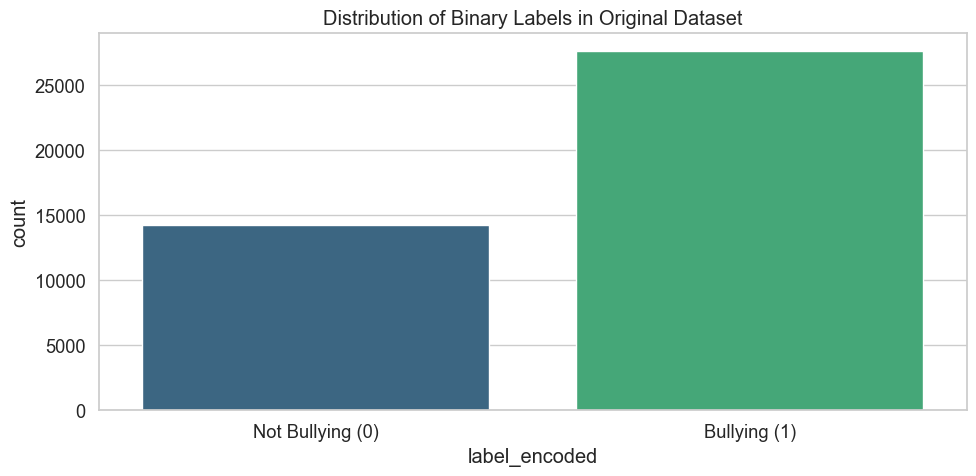

In [5]:
# Check the distribution of binary labels
plt.figure(figsize=(10, 5))
sns.countplot(x="label_encoded", data=original_cleaned_df, palette="viridis")
plt.title("Distribution of Binary Labels in Original Dataset")
plt.xticks([0, 1], ["Not Bullying (0)", "Bullying (1)"])
plt.tight_layout()
plt.show()

## 3. Data Splitting and Augmentation

In [6]:
# Split the original dataset into train and test sets
X = original_cleaned_df["comment"]
y = original_cleaned_df["label_encoded"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size before augmentation: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Training set size before augmentation: 33525
Test set size: 8382


In [7]:
# Add augmented data to the training set
X_aug = only_augmented_cleaned_df["text"]
y_aug = only_augmented_cleaned_df["label_encoded"]

# Concatenate original training data with augmented data
X_train_augmented = pd.concat([X_train, X_aug])
y_train_augmented = pd.concat([y_train, y_aug])

print(f"Training set size after augmentation: {len(X_train_augmented)}")

Training set size after augmentation: 39606


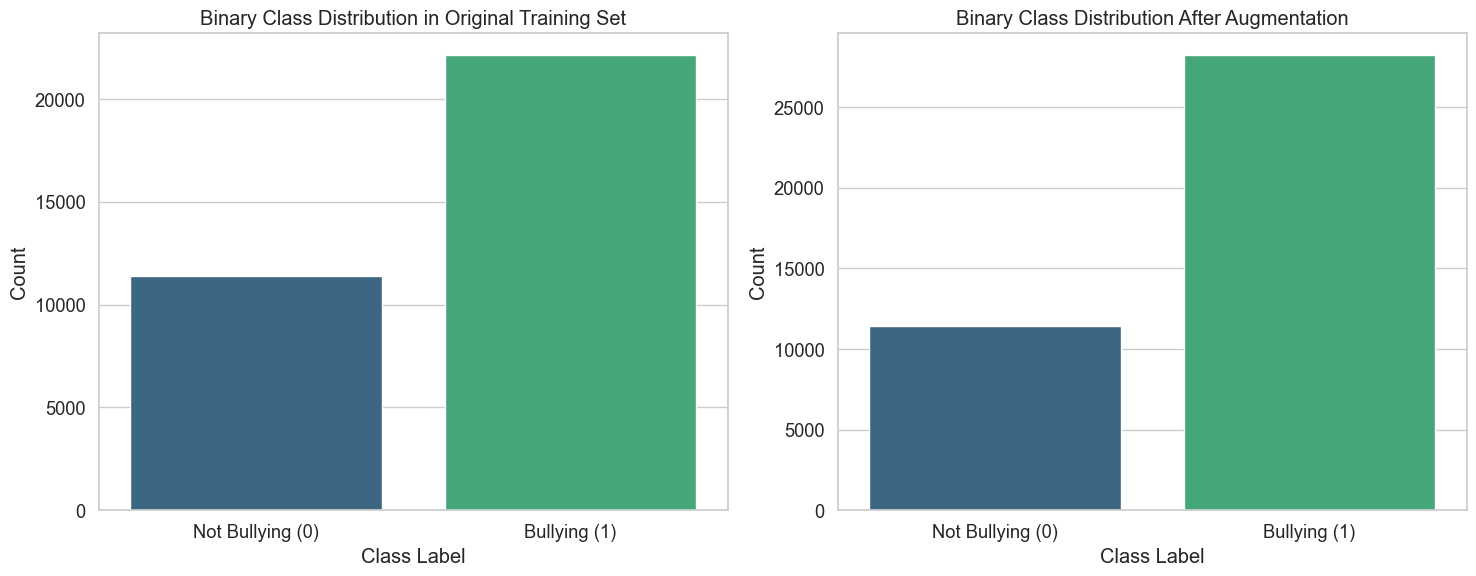

In [8]:
# Visualize the binary class distribution before and after augmentation
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.countplot(x=y_train, palette="viridis")
plt.title("Binary Class Distribution in Original Training Set")
plt.xlabel("Class Label")
plt.xticks([0, 1], ["Not Bullying (0)", "Bullying (1)"])
plt.ylabel("Count")

plt.subplot(1, 2, 2)
sns.countplot(x=y_train_augmented, palette="viridis")
plt.title("Binary Class Distribution After Augmentation")
plt.xlabel("Class Label")
plt.xticks([0, 1], ["Not Bullying (0)", "Bullying (1)"])
plt.ylabel("Count")

plt.tight_layout()
plt.show()

## 4. Text Tokenization and Sequence Preparation

In [9]:
# Initialize tokenizer from Keras for BiLSTM model
print("Initializing Keras tokenizer...")
MAX_NUM_WORDS = 10000  # Maximum number of words to keep
MAX_SEQUENCE_LENGTH = 100  # Maximum length of sequences

# Create a tokenizer that works on the Bangla text
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token='<UNK>')
tokenizer.fit_on_texts(pd.concat([X_train_augmented, X_test]))

# Get the word index and vocabulary size
word_index = tokenizer.word_index
print(f"Found {len(word_index)} unique tokens")

Initializing Keras tokenizer...
Found 78304 unique tokens


In [10]:
# Convert texts to sequences and pad them for LSTM input
def texts_to_sequences(texts):
    # Convert texts to sequences of integers
    sequences = tokenizer.texts_to_sequences(texts)
    # Pad sequences to ensure uniform length
    padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    return padded_sequences

In [11]:
# Apply tokenization and padding to training data
print("Converting training texts to sequences...")
start_time = time.time()
X_train_sequences = texts_to_sequences(X_train_augmented)
print(
    f"Training data sequence conversion completed in {time.time() - start_time:.2f} seconds"
)
print(f"Training sequence shape: {X_train_sequences.shape}")

Converting training texts to sequences...
Training data sequence conversion completed in 0.72 seconds
Training sequence shape: (39606, 100)


In [12]:
# Apply tokenization and padding to testing data
print("Converting testing texts to sequences...")
start_time = time.time()
X_test_sequences = texts_to_sequences(X_test)
print(f"Testing data sequence conversion completed in {time.time() - start_time:.2f} seconds")
print(f"Testing sequence shape: {X_test_sequences.shape}")

Converting testing texts to sequences...
Testing data sequence conversion completed in 0.14 seconds
Testing sequence shape: (8382, 100)


In [13]:
# Initialize embedding layer with Bengali FastText embeddings
print("Initializing word embedding matrix...")
EMBEDDING_DIM = 300  # FastText vectors are 300-dimensional
fasttext_model = BengaliFasttext()

# Create an embedding matrix using pre-trained FastText vectors
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    try:
        embedding_vector = fasttext_model.get_word_vector(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    except:
        continue  # Skip words not in the embedding model

print(f"Embedding matrix shape: {embedding_matrix.shape}")

Initializing word embedding matrix...
Embedding matrix shape: (78305, 300)


## 5. Building and Training BiLSTM Model

In [14]:
# Configure and create BiLSTM model
print("Building BiLSTM model...")

# Define model architecture
model = Sequential()
model.add(Embedding(len(word_index) + 1,  # Vocabulary size
                   EMBEDDING_DIM,        # Embedding dimension
                   weights=[embedding_matrix],  # Pre-trained embedding weights
                   input_length=MAX_SEQUENCE_LENGTH,
                   trainable=False))     # Keep embeddings fixed

model.add(SpatialDropout1D(0.3))  # Apply dropout to embeddings
model.add(Bidirectional(LSTM(128, return_sequences=True)))  # First BiLSTM layer
model.add(Dropout(0.3))  # Apply dropout for regularization
model.add(Bidirectional(LSTM(64)))  # Second BiLSTM layer
model.add(Dropout(0.3))  # Apply dropout for regularization
model.add(Dense(32, activation='relu'))  # Dense layer
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# Compile model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Display model summary
model.summary()

Building BiLSTM model...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │    23,491,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,491,500 (89.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,491,500 (89.61 MB)

In [ ]:
# Define callbacks for early stopping and model checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('../../models/lstm/binary_bilstm_best.h5', 
                                 monitor='val_accuracy', 
                                 save_best_only=True, 
                                 mode='max')

# Train the BiLSTM model
print("Training BiLSTM model...")
start_time = time.time()

history = model.fit(
    X_train_sequences,
    y_train_augmented,
    validation_split=0.1,  # Use 10% of training data as validation
    epochs=10,            # Training for 10 epochs
    batch_size=64,        # Batch size
    callbacks=[early_stopping, model_checkpoint]
)

training_time = time.time() - start_time
print(f"Model trained in {training_time:.2f} seconds")

Training BiLSTM model...
Epoch 1/10
557/557 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.6792 - loss: 0.6740

557/557 ━━━━━━━━━━━━━━━━━━━━ 74s 124ms/step - accuracy: 0.6792 - loss: 0.6740 - val_accuracy: 1.0000 - val_loss: 0.5053
Epoch 2/10
401/557 ━━━━━━━━━━━━━━━━━━━━ 18s 116ms/step - accuracy: 0.6810 - loss: 0.6357

In [ ]:
# Visualize training history
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

## 6. Model Evaluation - Basic Metrics

In [ ]:
# Make predictions and calculate basic metrics
print("Evaluating model...")
y_pred_proba = model.predict(X_test_sequences)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()  # Convert probabilities to class labels

# Calculate basic metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")
f1 = f1_score(y_test, y_pred, average="weighted")

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

In [ ]:
# Display classification report for binary classification
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Not Bullying", "Bullying"]))

## 7. Confusion Matrix Visualization

In [ ]:
# Create and display confusion matrix for binary classification
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]  # Normalize
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=["Not Bullying", "Bullying"],
    yticklabels=["Not Bullying", "Bullying"],
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Binary Classification Confusion Matrix")
plt.tight_layout()
plt.show()

## 8. Model Analysis

In [ ]:
# Analyze model performance on different examples
def predict_text(text):
    # Convert to sequence and predict
    sequence = texts_to_sequences([text])
    prediction = model.predict(sequence)[0][0]
    predicted_class = 'Bullying' if prediction > 0.5 else 'Not Bullying'
    return predicted_class, prediction

# Sample some examples from test set for analysis
sample_indices = np.random.choice(range(len(X_test)), 10, replace=False)
sample_texts = X_test.iloc[sample_indices].values
sample_labels = y_test.iloc[sample_indices].values

for i, (text, true_label) in enumerate(zip(sample_texts, sample_labels)):
    predicted_class, confidence = predict_text(text)
    true_class = 'Bullying' if true_label == 1 else 'Not Bullying'
    print(f"Example {i+1}:")
    print(f"Text: {text[:100]}..." if len(text) > 100 else f"Text: {text}")
    print(f"True class: {true_class}")
    print(f"Predicted class: {predicted_class} (confidence: {confidence:.4f})")
    print("-" * 80)

## 9. ROC Curve Analysis

In [ ]:
# ROC Curve and AUC for binary classification
y_score = model.predict(X_test_sequences).flatten()  # Probability of positive class

# Calculate ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Binary Classification ROC Curve')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

## 10. Precision-Recall Curve Analysis

In [ ]:
# Calculate Precision-Recall curve for binary classification
precision, recall, _ = precision_recall_curve(y_test, y_score)
avg_precision = precision_score(y_test, y_pred)

plt.figure(figsize=(10, 8))
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AP = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Binary Classification Precision-Recall Curve')
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

## 11. Model Summary and Saving

In [ ]:
# Summary of the binary classification model
print("Binary Classification BiLSTM Model Summary:")
print(f"Total samples in training set (with augmentation): {len(X_train_augmented)}")
print(f"Total samples in test set: {len(X_test)}")
print(f"Vocabulary size: {len(word_index)}")
print(f"Maximum sequence length: {MAX_SEQUENCE_LENGTH}")
print(f"Embedding dimension: {EMBEDDING_DIM}")
print(f"Final model accuracy on test set: {accuracy:.4f}")
plt.show()

In [ ]:
# Save the model
model.save("../../models/lstm/binary_bilstm_final.h5")

# Also save the tokenizer for future use
import pickle
with open("../../models/lstm/binary_tokenizer.pickle", "wb") as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("Model and tokenizer saved successfully.")